In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  9 04:37:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Imports**

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install transformers
from transformers import get_linear_schedule_with_warmup, AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re, string
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from transformers import BertModel, BertTokenizer
LABELS = ["Real  (1)", "Fake  (-1)"]

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 14.2 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 6.6 MB 62.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)
device = torch.device("cuda")

In [5]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Dataset**

In [6]:
colnames=['user_id', 'prod_id', 'rating', 'label','date'] 

In [7]:
df_meta = pd.read_csv('/content/drive/MyDrive/Data/YelpNYC/metadata',names=colnames,header=None,sep='\t')

In [8]:
df_meta

,user_id,prod_id,rating,label,date
0,923,0,3.0,-1,2014-12-08
1,924,0,3.0,-1,2013-05-16
2,925,0,4.0,-1,2013-07-01
3,926,0,4.0,-1,2011-07-28
4,927,0,4.0,-1,2010-11-01
...,...,...,...,...,...
359047,161146,349,5.0,1,2014-02-06
359048,116424,349,5.0,1,2014-01-31
359049,161147,349,5.0,1,2014-01-30
359050,97930,349,5.0,1,2014-01-25


In [9]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359052 entries, 0 to 359051
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  359052 non-null  int64  
 1   prod_id  359052 non-null  int64  
 2   rating   359052 non-null  float64
 3   label    359052 non-null  int64  
 4   date     359052 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 13.7+ MB


In [10]:
df_content = pd.read_csv('/content/drive/MyDrive/Data/YelpNYC/reviewContent',sep='\t',names=['user_id', 'prod_id','date','text'] )

In [11]:
df_content

,user_id,prod_id,date,text
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...
...,...,...,...,...
358952,161146,349,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr..."
358953,116424,349,2014-01-31,Can't say enough good things about this place....
358954,161147,349,2014-01-30,"Had a great dinner here- fantastic pizza, the ..."
358955,97930,349,2014-01-25,"Great foods and great drinks, they have even p..."


In [12]:
data = pd.merge(df_content, df_meta, on=['user_id', 'prod_id','date'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358957 entries, 0 to 358956
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  358957 non-null  int64  
 1   prod_id  358957 non-null  int64  
 2   date     358957 non-null  object 
 3   text     358957 non-null  object 
 4   rating   358957 non-null  float64
 5   label    358957 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 19.2+ MB


In [14]:
data

,user_id,prod_id,date,text,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,3.0,-1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,3.0,-1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,4.0,-1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,4.0,-1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,4.0,-1
...,...,...,...,...,...,...
358952,161146,349,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1
358953,116424,349,2014-01-31,Can't say enough good things about this place....,5.0,1
358954,161147,349,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",5.0,1
358955,97930,349,2014-01-25,"Great foods and great drinks, they have even p...",5.0,1


In [15]:
data = data.drop(['user_id', 'prod_id','rating','date'], axis = 1)

In [16]:
data

,text,label
0,The food at snack is a selection of popular Gr...,-1
1,This little place in Soho is wonderful. I had ...,-1
2,ordered lunch for 15 from Snack last Friday. ...,-1
3,This is a beautiful quaint little restaurant o...,-1
4,Snack is great place for a casual sit down lu...,-1
...,...,...
358952,"I'm very spoiled with Pizza. Really, I have tr...",1
358953,Can't say enough good things about this place....,1
358954,"Had a great dinner here- fantastic pizza, the ...",1
358955,"Great foods and great drinks, they have even p...",1


In [17]:
data.drop_duplicates(keep=False,inplace=True)

In [18]:
data

,text,label
0,The food at snack is a selection of popular Gr...,-1
1,This little place in Soho is wonderful. I had ...,-1
2,ordered lunch for 15 from Snack last Friday. ...,-1
3,This is a beautiful quaint little restaurant o...,-1
4,Snack is great place for a casual sit down lu...,-1
...,...,...
358952,"I'm very spoiled with Pizza. Really, I have tr...",1
358953,Can't say enough good things about this place....,1
358954,"Had a great dinner here- fantastic pizza, the ...",1
358955,"Great foods and great drinks, they have even p...",1


In [19]:
data['label'].value_counts()

 1    321499
-1     36466
Name: label, dtype: int64

Text(0, 0.5, 'Frequency')

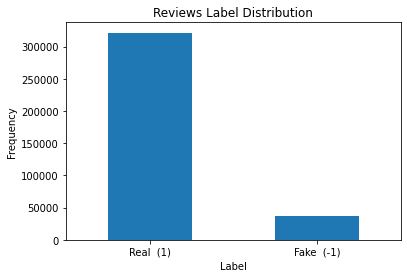

In [20]:
cnt_classes = pd.value_counts(data['label'], sort = True)
cnt_classes.plot(kind = 'bar', rot=0)
plt.title("Reviews Label Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency")

**Down-Sampling**

In [21]:
X = data.drop(['label'], axis=1)
y = data['label']

In [22]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1) 
X_res, y_res = rus.fit_resample(X, y)

In [23]:
data_new = pd.concat([y_res, X_res],axis=1)

In [24]:
data_new

,label,text
0,-1,The food at snack is a selection of popular Gr...
1,-1,This little place in Soho is wonderful. I had ...
2,-1,ordered lunch for 15 from Snack last Friday. ...
3,-1,This is a beautiful quaint little restaurant o...
4,-1,Snack is great place for a casual sit down lu...
...,...,...
72927,1,Really cool late night place! Unbelievable pri...
72928,1,I really enjoyed my lunch here -- avoid the lo...
72929,1,Chain food? Yes. Ample seatin...
72930,1,I went to Bayou for the first time last night ...


Text(0, 0.5, 'Frequency')

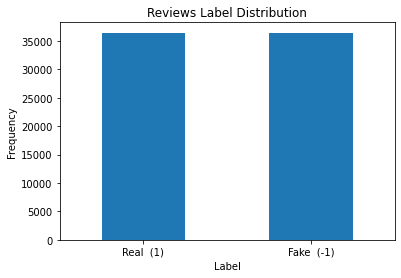

In [25]:
cnt_classes = pd.value_counts(data_new['label'], sort = True)
cnt_classes.plot(kind = 'bar', rot=0)
plt.title("Reviews Label Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency")

In [26]:
data_new['label'].value_counts()

-1    36466
 1    36466
Name: label, dtype: int64

In [27]:
data_new

,label,text
0,-1,The food at snack is a selection of popular Gr...
1,-1,This little place in Soho is wonderful. I had ...
2,-1,ordered lunch for 15 from Snack last Friday. ...
3,-1,This is a beautiful quaint little restaurant o...
4,-1,Snack is great place for a casual sit down lu...
...,...,...
72927,1,Really cool late night place! Unbelievable pri...
72928,1,I really enjoyed my lunch here -- avoid the lo...
72929,1,Chain food? Yes. Ample seatin...
72930,1,I went to Bayou for the first time last night ...


In [28]:
data_new.loc[data_new["label"] == -1, "label"] = 0

In [29]:
data_new

,label,text
0,0,The food at snack is a selection of popular Gr...
1,0,This little place in Soho is wonderful. I had ...
2,0,ordered lunch for 15 from Snack last Friday. ...
3,0,This is a beautiful quaint little restaurant o...
4,0,Snack is great place for a casual sit down lu...
...,...,...
72927,1,Really cool late night place! Unbelievable pri...
72928,1,I really enjoyed my lunch here -- avoid the lo...
72929,1,Chain food? Yes. Ample seatin...
72930,1,I went to Bayou for the first time last night ...


In [73]:
data = data_new

In [55]:
data

,label,text
0,0,The food at snack is a selection of popular Gr...
1,0,This little place in Soho is wonderful. I had ...
2,0,ordered lunch for 15 from Snack last Friday. ...
3,0,This is a beautiful quaint little restaurant o...
4,0,Snack is great place for a casual sit down lu...
...,...,...
64995,1,"ew. no, thank you! better off eating at The Ol..."
64996,1,The best halal food in the city hands down. Th...
64997,1,Huge portions and darn good value on a weekday...
64998,1,I have to agree with Frank Bruni and say that ...


In [56]:

data

,label,text
0,0,The food at snack is a selection of popular Gr...
1,0,This little place in Soho is wonderful. I had ...
2,0,ordered lunch for 15 from Snack last Friday. ...
3,0,This is a beautiful quaint little restaurant o...
4,0,Snack is great place for a casual sit down lu...
...,...,...
64995,1,"ew. no, thank you! better off eating at The Ol..."
64996,1,The best halal food in the city hands down. Th...
64997,1,Huge portions and darn good value on a weekday...
64998,1,I have to agree with Frank Bruni and say that ...


In [57]:
# Instantiate BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

**Corpus tokenization using Bert**

In [58]:
def corpus_tokenize(data, tokenizer, max_len):
    # For storing token ids
    input_ids = []
    # Storage for attention masks
    attention_masks = []
    #At max it can be 512
    max_len = max_len
    # Go through every document
    for df in data:
        encoded_dict = tokenizer.encode_plus(
                            df,  # document to encode.
                            add_special_tokens=True,  #  '[CLS]' and '[SEP]' token add
                            max_length=max_len,  # value for max length
                            truncation=True,  # if longer messages then truncate 
                            pad_to_max_length=True,  # add padding
                            return_attention_mask=True,  #  attn. masks creation
                            return_tensors='pt'  # pytorch tensor return
                       )

        # To include tokenized token in the list
        input_ids.append(encoded_dict['input_ids'])

        # Attention mask
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


**Generate tokenized data**

In [59]:
input_ids, attention_masks = corpus_tokenize(data['text'].values, tokenizer, 256)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Label to tensor conversion**

In [60]:
labels = torch.tensor(data_new['label'].values.astype(np.float32))

**Get tensor dataset ready**

In [61]:
def prep_dataset(padded_tokens, attention_masks, target):
    # Ready the target for the np array
    target = np.array(target.values, dtype=np.int64).reshape(-1, 1)
    # Build tensor data sets
    tensor_data = TensorDataset(padded_tokens, attention_masks, torch.from_numpy(target))
    # 80% of data for train
    train_size = int(0.8 * len(data))
    # 20% of data
    val_size = len(data) - train_size
    # 50% of validation
    test_size = int(val_size - 0.5*val_size)
    # By choosing samples at random, split the dataset.
    train_data, val_data = random_split(tensor_data, [train_size, val_size])
    # Samples are chosen at random to divide validation
    val_data, test_data = random_split(val_data, [test_size, test_size]) #keep test_size+1 for yelp nyc

    return train_data, val_data, test_data


# Build tensor dataset
train_data, val_data, test_data = prep_dataset(input_ids,attention_masks,data['label'])

In [62]:
#  To count the target distribution inside the tensor dataset
def target_cnt(tensor_data):
    cnt0 = 0
    cnt1 = 0
    final = []
    # Each item in the tensor data set
    for dat in tensor_data:
        # for target = 0
        if dat[2].item() == 0:
            cnt0 += 1
        # for target = 1
        elif dat[2].item() == 1:
            cnt1 += 1
    final.append(cnt0)
    final.append(cnt1)
    return torch.tensor(final)

# For imbalanced classification prepare weighted sampling
def prep_sampler(target_tensor, tensor_data):
    #  class distributions [x, y]
    class_sample_cnt = target_cnt(tensor_data)
    # weight
    weight = 1. / class_sample_cnt.float()
    # For each observation in dataset produce weight
    samples_weight = torch.tensor([weight[t[2]] for t in tensor_data])
    # prepare sampler
    sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weight,
                                                     num_samples=len(samples_weight),
                                                     replacement=True)
    return sampler


# samplers for train set 
train_sampler = prep_sampler(target_cnt(train_data), train_data)


# Function to return time 
def format_time(elapsed):
    '''
    hh:mm:ss
    '''
    time_elapsed = int(round((elapsed)))
    #  hh:mm:ss
    return str(datetime.timedelta(seconds=time_elapsed))

**Dataloaders**

In [63]:
train_dataloader = DataLoader(train_data,
                              batch_size=16,
                              sampler=train_sampler,
                              shuffle=False)

valid_dataloader = DataLoader(val_data,
                              batch_size=16,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                              batch_size=16,
                              shuffle=True)

**BERT-CNN model**

In [64]:
class BERTCNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        # Kernels
        output_channel = config.output_channel  
        # Labels
        num_label = config.num_label  
        # Dropout value
        dropout = config.dropout  
        # length of embedding dim
        embed_dim = config.embed_dim  
        # conv net
        cn = 3  # conv net

        
        input_channel = 4  

        # 3 Convolutional nets
        self.conv1 = nn.Conv2d(input_channel, output_channel, (3, embed_dim), padding=(2, 0), groups=4)
        self.conv2 = nn.Conv2d(input_channel, output_channel, (4, embed_dim), padding=(3, 0), groups=4)
        self.conv3 = nn.Conv2d(input_channel, output_channel, (5, embed_dim), padding=(4, 0), groups=4)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(cn * output_channel, num_label)

    def forward(self, x, **kwargs):
        # squeeze to get size
        x = [F.relu(self.conv1(x)).squeeze(3), F.relu(self.conv2(x)).squeeze(3), F.relu(self.conv3(x)).squeeze(3)]
        # Max-over-time pooling
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        # Concat results
        x = torch.cat(x, 1)
        # Add Dropout
        x = self.dropout(x)
        # Generate logits which contains batch and target size
        logit = self.fc1(x)
        return logit

**Training**

In [65]:
def train(model, dataloader, optimizer):

    # Record Time
    total_t = time.time()

    # For one full pass for training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('..........Training..........')

    #After calculating loss reset total loss for epoch
    train_total_loss = 0
    train_total_f1 = 0

    # Training mode
    model.train()
    hyb_model.train()

    # Training data for each batch
    for itr, batch in enumerate(dataloader):

        # Updation after every 40 batches
        if itr % 40 == 0 and not itr == 0:

            # Progress
            print('  Batch {:>5,}  of  {:>5,}.'.format(itr, len(dataloader)))

        # This training batch has been unpacking from dataloader
        batch_input_ids = batch[0].cuda()
        batch_input_mask = batch[1].cuda()
        batch_labels = batch[2].cuda().long()

        # To remove any previously calculated gradients.
        optimizer.zero_grad()

        # Executes an autocasting forward pass.
        with autocast():
            # Advance propagation (evaluate model on training batch)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_mask)
            #Discover hidden layers and stack the layers
            hidden_layers = outputs[2]  
            # stack the layers
            hidden_layers = torch.stack(hidden_layers, dim=1)  
            # Last 4 layers
            hidden_layers = hidden_layers[:, -4:]  

        logits = hyb_model(hidden_layers)

        loss = criterion(logits.view(-1, 2), batch_labels.view(-1))

        # Sum the training loss over all batches to calculate average loss.
        train_total_loss += loss.item()

        # In order to produce scaled gradients
        scaler.scale(loss).backward()

         # Unscales the gradients of the optimizer's assigned parameters.
        scaler.step(optimizer)

        # Next iteration's scale update
        scaler.update()

        # Refresh the scheduler
        scheduler.step()

        # Determine preds
        _, pred = torch.max(logits, 1)

        # Move logits and labels to CPU
        pred = pred.detach().cpu().numpy()
        y_true = batch_labels.detach().cpu().numpy()

        # F1
        train_total_f1 += f1_score(pred, y_true,
                                   average='weighted',
                                   labels=np.unique(pred))

    # Average loss for all the batches 
    train_avg_loss = train_total_loss / len(dataloader)

    # Calculate the average f1 over all of the batches
    train_avg_f1 = train_total_f1 / len(dataloader)

    # Length of training
    train_time = format_time(time.time() - total_t)

    # The necessary statistics for the current epoch
    stats_train.append(
        {
            'Train Loss': train_avg_loss,
            'Train F1': train_avg_f1,
            'Train Time': train_time
        }
    )

    # Result
    print("")
    print("..........Summary..........")
    print("epoch | trn loss | trn f1 | trn time ")
    print(f"{epoch+1:5d} | {train_avg_loss:.5f} | {train_avg_f1:.5f} | {train_time:}")

    return None

**Validation**

In [66]:
def validating(model, dataloader):

    # Record Time
    total_t = time.time()

    # After each training cycle is over, evaluate performance against the validation set.
    print("")
    print("..........Running Validation..........")

    # Place the evaluation mode on both models.
    model.eval()
    hyb_model.eval()

    # Monitor variables
    val_total_accuracy = 0
    val_total_loss = 0
    val_total_f1 = 0
    val_total_recall = 0
    val_total_precision = 0
    val_bert_total_loss = 0

    # Analyze information for one epoch.
    for batch in dataloader:

        # This training batch has been unpacked from dataloader:
        batch_input_ids = batch[0].cuda()
        batch_input_mask = batch[1].cuda()
        batch_labels = batch[2].cuda().long()

        
        with torch.no_grad():
            # Model evaluation using training batch
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_mask)

            hidden_layers = outputs[2]  

            hidden_layers = torch.stack(hidden_layers, dim=1) 

            hidden_layers = hidden_layers[:, -4:] 

        logits = hyb_model(hidden_layers)

        loss = criterion(logits.view(-1, 2), batch_labels.view(-1))

        # Add up validation losses
        val_total_loss += loss.item()

        # Determine preds
        _, pred = torch.max(logits, 1)

        
        pred = pred.detach().cpu().numpy()
        y_true = batch_labels.detach().cpu().numpy()

        #F1
        val_total_f1 += f1_score(pred, y_true,
                                   average='weighted',
                                   labels=np.unique(pred))

        # Determine accuracy
        val_total_accuracy += accuracy_score(pred, y_true)

        # Determine precision
        val_total_precision += precision_score(pred, y_true,
                                                 average='weighted',
                                                 labels=np.unique(pred))

        # Determine recall
        val_total_recall += recall_score(pred, y_true,
                                                 average='weighted',
                                                 labels=np.unique(pred))

    # Report the validation run's final accuracy.
    val_avg_accuracy = val_total_accuracy / len(dataloader)

    # Report the validation run's final f1
    global val_avg_f1
    val_avg_f1 = val_total_f1 / len(dataloader)

    # Report the validation run's final precision
    val_avg_precision = val_total_precision / len(dataloader)

    # Report the validation run's final recall
    val_avg_recall = val_total_recall / len(dataloader)

    # Determine the average loss for all batches.
    global val_avg_loss
    val_avg_loss = val_total_loss / len(dataloader)

    # Record end time for validation.
    val_time = format_time(time.time() - total_t)

    # Keeps track of all data from this epocs
    stats_val.append(
        {
            'Val Loss': val_avg_loss,
            'Val Accur.': val_avg_accuracy,
            'Val precision': val_avg_precision,
            'Val recall': val_avg_recall,
            'Val F1': val_avg_f1,
            'Val Time': val_time
        }
    )

    # Result
    print("")
    print("..........Summary..........")
    print("epoch | val loss | val f1 | val time")
    print(f"{epoch+1:5d} | {val_avg_loss:.5f} | {val_avg_f1:.5f} | {val_time:}")

    return None

**Testing**

In [67]:
def testing(model, dataloader):

    print("")
    print("..........Running Testing..........")

    # Record test time
    total_t = time.time()

    # Evaluation mode
    model.eval()
    hyb_model.eval()

   
    test_total_accuracy = 0
    test_total_loss = 0
    test_total_f1 = 0
    test_total_recall = 0
    test_total_precision = 0

    
    for batch in dataloader:

        
        batch_input_ids = batch[0].cuda()
        batch_input_mask = batch[1].cuda()
        batch_labels = batch[2].cuda().long()

        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_mask)

            hidden_layers = outputs[2]  

            hidden_layers = torch.stack(hidden_layers, dim=1)  

            hidden_layers = hidden_layers[:, -4:]  

        logits = hyb_model(hidden_layers)

        loss = criterion(logits.view(-1, 2), batch_labels.view(-1))

        # Add up validation losses
        test_total_loss += loss.item()

        # Determine preds
        _, pred = torch.max(logits, 1)

        
        pred = pred.detach().cpu().numpy()
        y_true = batch_labels.detach().cpu().numpy()

        # Determine f1
        test_total_f1 += f1_score(pred, y_true,
                                   average='weighted',
                                   labels=np.unique(pred))

        # Determine accuracy
        test_total_accuracy += accuracy_score(pred, y_true)

        # Determine precision
        test_total_precision += precision_score(pred, y_true,
                                                 average='weighted',
                                                 labels=np.unique(pred))

        # Determine recall
        test_total_recall += recall_score(pred, y_true,
                                                 average='weighted',
                                                 labels=np.unique(pred))

    # Report the test's final accuracy
    test_avg_accuracy = test_total_accuracy / len(dataloader)

    # Report the test's final f1
    test_avg_f1 = test_total_f1 / len(dataloader)

    # Report the test's final precision
    test_avg_precision = test_total_precision / len(dataloader)

    # Report the test's final recall
    test_avg_recall = test_total_recall / len(dataloader)

    # Determine the cumulative loss for all batches.
    test_avg_loss = test_total_loss / len(dataloader)

    # Time for testing
    test_time = format_time(time.time() - total_t)

    # Keep track of all data from this epoch.
    stats_test.append(
        {
            'Test Loss': test_avg_loss,
            'Test Accur.': test_avg_accuracy,
            'Test precision': test_avg_precision,
            'Test recall': test_avg_recall,
            'Test F1': test_avg_f1,
            'Test Time': test_time
        }
    )
    # Result
    print("")
    print("..........Summary..........")
    print("epoch | test loss | test f1 | test time")
    print(f"{epoch+1:5d} | {test_avg_loss:.5f} | {test_avg_f1:.5f} | {test_time:}")

    return None

**Instantiate BERT model with hidden states**

In [68]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
class config:
    def __init__(self):
        config.num_label = 2  # binary
        config.output_channel = 16  # number of kernels
        config.embed_dim = 768  # embed dimension
        config.dropout = 0.4  # dropout value
        return None


# Create config
config1 = config()

# Instantiate CNN
hyb_model = BERTCNN(config1).cuda()

# set loss
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs = 4

# Train the final four layers
BERT_param = []
layers_used = [11, 10, 9, 8]

for name, param in model.named_parameters():
    for layer_num in layers_used:
        layer_num = str(layer_num)
        if ".{}.".format(layer_num) in name:
            BERT_param.append(param)

# Setup optimizer
optimizer = AdamW([{'params': BERT_param, 'lr': 2e-5}], weight_decay=1.0)


# Setup LR scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Developing a gradient scaler for mixed precision
scaler = GradScaler()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Result storage for training**

In [70]:
# Storing of training results
stats_train = []
stats_val = []
val_loss_best = float('inf')

for epoch in range(epochs):
    #Train
    train(model, train_dataloader, optimizer)
    # Validate
    validating(model, valid_dataloader)
    # Verify validation loss
    if stats_val[epoch]['Val Loss'] < val_loss_best:
        best_valid_loss = stats_val[epoch]['Val Loss']
        # Save the model for later usage.
        torch.save(model.state_dict(), 'bert-cnn-model1.pt')  
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('./model_save/bert-cnn/')  
        tokenizer.save_pretrained('./model_save/bert-cnn/')  


======== Epoch 1 / 4 ========
..........Training..........
  Batch    40  of    500.
  Batch    80  of    500.
  Batch   120  of    500.
  Batch   160  of    500.
  Batch   200  of    500.
  Batch   240  of    500.
  Batch   280  of    500.
  Batch   320  of    500.
  Batch   360  of    500.
  Batch   400  of    500.
  Batch   440  of    500.
  Batch   480  of    500.

..........Summary..........
epoch | trn loss | trn f1 | trn time 
    1 | 0.65055 | 0.62707 | 0:12:16

..........Running Validation..........

..........Summary..........
epoch | val loss | val f1 | val time
    1 | 0.59636 | 0.69729 | 0:00:20

======== Epoch 2 / 4 ========
..........Training..........
  Batch    40  of    500.
  Batch    80  of    500.
  Batch   120  of    500.
  Batch   160  of    500.
  Batch   200  of    500.
  Batch   240  of    500.
  Batch   280  of    500.
  Batch   320  of    500.
  Batch   360  of    500.
  Batch   400  of    500.
  Batch   440  of    500.
  Batch   480  of    500.

..........

In [71]:
# Results
pd.set_option('precision', 3)
train_data_stats = pd.DataFrame(data=stats_train)
valid_data_stats = pd.DataFrame(data=stats_val)
stats_data = pd.concat([train_data_stats, valid_data_stats], axis=1)
stats_data.insert(0, 'Epoch', range(1, len(stats_data)+1))
stats_data = stats_data.set_index('Epoch')
stats_data

,Train Loss,Train F1,Train Time,Val Loss,Val Accur.,Val precision,Val recall,Val F1,Val Time
Epoch,,,,,,,,,
1,0.651,0.627,0:12:16,0.596,0.696,0.722,0.696,0.697,0:00:20
2,0.595,0.692,0:12:18,0.573,0.705,0.729,0.705,0.704,0:00:20
3,0.559,0.722,0:12:18,0.567,0.715,0.744,0.715,0.716,0:00:20
4,0.559,0.721,0:12:18,0.565,0.704,0.724,0.704,0.703,0:00:20


**Testing Results**

In [72]:
stats_test = []
model.load_state_dict(torch.load('/content/bert-cnn-model1.pt'))
testing(model, test_dataloader)
test_data_stats = pd.DataFrame(data=stats_test)
test_data_stats


..........Running Testing..........

..........Summary..........
epoch | test loss | test f1 | test time
    4 | 0.60611 | 0.67465 | 0:00:20


,Test Loss,Test Accur.,Test precision,Test recall,Test F1,Test Time
0,0.606,0.676,0.707,0.676,0.675,0:00:20
